In [44]:
#%pip install git+https://github.com/ShunChi100/RobustPCA

#### Fonte
https://github.com/dganguli/robust-pca

In [45]:
from rpca import R_pca
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [46]:
def read_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # List to store frames
    frames = []
    
    # Read frames from the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames
        
        # Convert frame to grayscale (if needed)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Convert to uint8
        gray_frame = gray_frame.astype(np.uint8)
        
        # Append the frame to the list
        frames.append(gray_frame)

    # Release the video capture object
    cap.release()
    
    # Convert list of frames to a numpy array
    video_data = np.array(frames)
    return video_data

In [47]:
def noisemodel(frames, sigma, k, s):
    """
    Add Gaussian, Poisson, and Impulsive noise to the video.

    Parameters:
    frames (np.ndarray): Original video of shape (dim1, dim2, nframes) (uint8).
    sigma (float): Standard deviation of Gaussian noise.
    k (float): Variance factor of Poisson noise.
    s (float): Percentage of impulsive noise.

    Returns:
    np.ndarray: Noisy video of shape (dim1, dim2, nframes) (uint8).
    """
    dim1, dim2, nframes = frames.shape

    # Convert frames to float for noise addition
    noisy = frames.astype(np.float64)

    # Poisson Noise
    np_noise = np.random.poisson(k * noisy) - k * noisy

    # Gaussian Noise
    ng = sigma * np.random.randn(dim1, dim2, nframes)

    # Combine noises
    noisy += np_noise + ng

    # Impulsive noise
    X = np.random.rand(dim1, dim2, nframes)
    noisy[X < s / 200] = 0  # Set impulsive noise to 0
    noisy[X > 1 - s / 200] = 255  # Set impulsive noise to 255

    # Cast back to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    return noisy

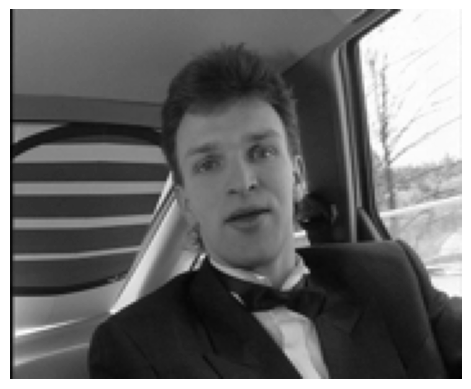

In [48]:
video = read_video('../data/carphone_qcif.y4m')
fig = plt.figure()
plt.imshow(video[0], cmap='gray')
plt.axis('off')
plt.show()

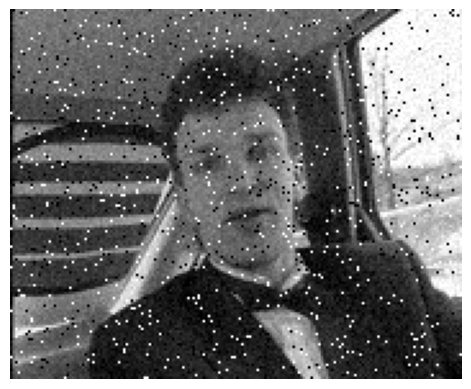

In [49]:
noisy = noisemodel(video, 10, 0.01, 5)
fig = plt.figure()
plt.imshow(noisy[0], cmap='gray')
plt.axis('off')
plt.show()

Vamos tomar uma abordagem simples (não temporal, primeira sugerida no artigo)

$M = L + S$

onde espera-se que $S$ contenha o ruído.

In [50]:
'''l_ = []
s_ = []
for frame in tqdm(noisy):
    rpca = R_pca(frame)
    #L, S = rpca.fit(max_iter=10000, iter_print=100)
    L, S = rpca.fit(max_iter=500, iter_print=500)
    l_.append(L)
    s_.append(S)'''

frame = noisy[0]
rpca = R_pca(frame)
L, S = rpca.fit(max_iter=1000, iter_print=100)

iteration: 1, error: 31.818854006338036
iteration: 100, error: 0.6725683810337435
iteration: 200, error: 0.4157702865548003
iteration: 300, error: 0.21573548227024245
iteration: 400, error: 0.13616792594989
iteration: 500, error: 0.03987063019477534
iteration: 600, error: 0.021414616738421068
iteration: 700, error: 0.013274843068554537
iteration: 800, error: 0.008445796873358941
iteration: 900, error: 0.006264188916320487
iteration: 1000, error: 0.003920090253762216


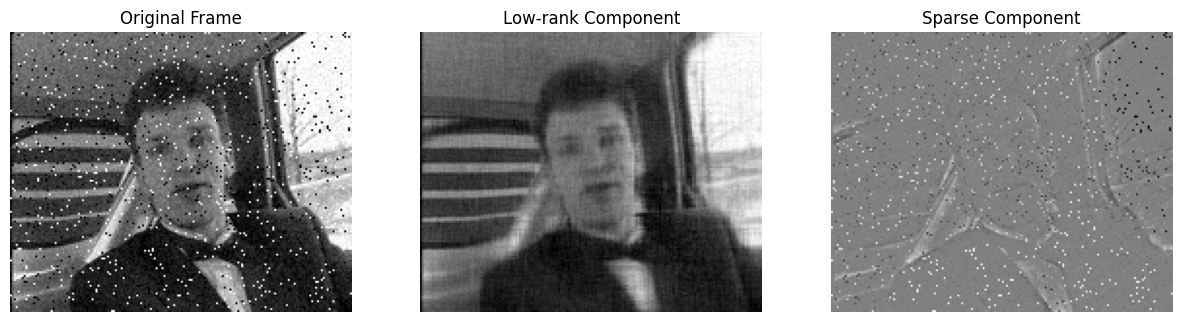

In [51]:
# plot original frame, L and S, side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original Frame')
axs[0].axis('off')
axs[1].imshow(L, cmap='gray')
axs[1].set_title('Low-rank Component')
axs[1].axis('off')
axs[2].imshow(S, cmap='gray')
axs[2].set_title('Sparse Component')
axs[2].axis('off')
plt.show()